In [1]:
from selenium import webdriver
import time
import random
from bs4 import BeautifulSoup
import re
from datetime import datetime
import json
import pandas as pd

In [54]:
class Insta_Crawling():

    def __init__(self):    #크롬 창을 연다
        self.browser = webdriver.Chrome('C:/informs/chromedriver')
            
    def searching_tag(self, word):
        # 해쉬태그 검색결과 화면에 접속한다
        url = 'https://www.instagram.com/explore/tags/{}'.format(word)
        self.browser.get(url)
        self.browser.implicitly_wait(3)
        time.sleep(random.uniform(0.3,0.7))  #추가시간 대기
             
        article_count = self.browser.find_element_by_css_selector('span._t98z6 > span._fd86t').text
        print('{}에 대해서 {}개의 게시물을 확인하였습니다'.format(word, article_count))
        return article_count
    
    
    def searching_name(self,name): 
        # 인스타 아이디를 통해 개인페이지에 접속한다
        url = 'https://www.instagram.com/{}'.format(name)
        self.browser.get(url)
        self.browser.implicitly_wait(3)
        time.sleep(random.uniform(0.3,0.7))  #추가시간 대기    
        
        
        
    def get_information_name(self):     
        # 개인페이지 내에서 정보를 추출한다: 아이디/소개글/컨텐츠수/팔로워수/팔로우수
        
        html = self.browser.page_source
        soup = BeautifulSoup(html,'lxml')
        name = soup.select('#react-root div._ienqf > h1')[0].text
        intro = soup.select('#react-root div._tb97a')[0].text
        contents_count = soup.select('#react-root ul > li > span > span')[0].text
        follower_count = soup.select('#react-root ul > li > span > span')[1].text
        follow_count = soup.select('#react-root ul > li > span > span')[2].text

        informs = {
            "insta_id": name,
            "intro" : intro,
            "contents_count":contents_count,
            "follower_count":follower_count,
            "follow_count":follow_count
        }
        return informs
      
    
    def click_first_photo(self):
    # 첫번째 게시글
        first_photo = self.browser.find_element_by_xpath('//*[@id="react-root"]/section/main/article/div[1]/div/div[1]/div[1]/a')
        first_photo.click()
           
    def move_to_next(self):
        # 다음 게시글로 넘어간다
        next_button = self.browser.find_element_by_css_selector('a._3a693.coreSpriteRightPaginationArrow')   
        next_button.click()
        
        
    def out_photo(self):
        # 사진 조회화면에서 나간다(검색화면으로 돌아감)
        out_button = self.browser.find_element_by_css_selector('button._dcj9f')
        out_button.click()

        
    def get_contents(self):
        # 사진보기에 나와있는 정보를 가져온다: 작성자/본문/태그/리플/좋아요or조회수
        
        # 댓글이 있을 경우 다 나올때까지 댓글 더보기를 눌러준다(더보기 한번에 20개씩 나옴)
        i = 0
        while(1):
            try:
                more_replys = self.browser.find_element_by_css_selector('ul > li._56pd5 > a._m3m1c._1s3cd')
                more_replys.click()
                i+=1
                time.sleep(random.uniform(0.01,0.05))
            except: break        
        
        html = self.browser.page_source
        soup = BeautifulSoup(html,'lxml')
              
        contents = soup.select('ul._b0tqa > li._ezgzd')[0]
        writer = contents.select('a')[0].text
        article = contents.select('span')[0].text
        
        tags = re.findall(r'#[^#\s\',\(\)!\.~\-/&\+\*$]+', article)  #태그만 걸러줌
        
        reply_lists = soup.select('ul._b0tqa > li._ezgzd')[1:]
        replys = []
        for i,reply in enumerate(reply_lists):
            who = reply.select('a')[0].text
            what = reply.select('span')[0].text
            replys.append((i+1,who,what))
        replys_count = str(len(replys))
#         if replys_count == 0 : replys.append('0')   # 리플이 없다면 0 으로 표시
        
        
        datet = soup.select('time')[0]['datetime']    #2017-04-13T10:16:52.000Z  형태    
        datet = datetime.strptime(datet,'%Y-%m-%dT%H:%M:%S.000Z')
        datet = datet.strftime('%Y-%m-%d %H:%M')   #연/월/일 시:분 표시함
        
        
        img_link = soup.select('div._4rbun > img')[0]['src']
        
        # 좋아요 or 조회수 를 가져온다
        try:
            # 좋아요/조회수가 클 경우 숫자를 바로 가져옴
            likes = soup.select('div._ebcx9 > section._1w76c._nlmjy > div > span > span')[0].text   
        except: 
            try:
                # 좋아요 수가 적을 경우, 좋아요 누른 아이디 수를 카운트 함
                likes = len(soup.select('div._ebcx9 > section._1w76c._nlmjy > div > a'))
            except: likes = 0
        
        inform = {
            "writer":writer,
            "article":article,
            "likes":likes,
            "replys_count": replys_count,
            "replys": replys,
            "datetime": datet,
            "img":img_link,
            "tags":tags
        }
        
        print("  <정보수집중> : {}".format(article[:30]))

        return inform

    
    def save_to_json(self, datas, fname):
        now = datetime.now()
        with open(fname,'w', encoding = 'utf-8') as save:
            json.dump(datas, save)
        print('\n검색결과를 저장하였습니다: {}'.format(fname))
        
    def load_datas_jason(self, fname):
        #json 불러오기
        results = []
        with open(fname, 'r', encoding ='utf-8') as save:
            results = json.load(save)
        return results

    
    
    def save_to_csv(self,datas,fname):

        cols = ['writer','article','likes','replys_count','replys','datetime','img','tags']

        datas_list = []
        
        for data in datas:   #게시글 정보를 하나씩 불러와서
            line = ''     
            for col in cols:     # 문자열로 변환 후, 리스트로 나누어준다
                l = str(data[col])
                if col in ['replys','tags']:   l = l[1:-1]
                line += l+"!@@#@!"
            datas_list.append(line.split('!@@#@!')[:-1])

        datas_df = pd.DataFrame(datas_list)
        datas_df.columns = cols
        datas_df.to_csv(fname, inex = False, encoding = 'utf-8-sig')

        print('\n검색결과를 저장하였습니다: {}'.format(fname))
        
    def load_datas_csv(self, fname):  return pd.read_csv(fname, encoding = 'utf-8-sig')
    
    
    def crwaling_by_tag(self, tag, count):
        
        self.searching_tag(tag)
        time.sleep(2)
        self.click_first_photo()
        
        datas = []
        for i in range(count):
            data = self.get_contents()
            time.sleep(random.uniform(0.5,1))
            datas.append(data)
            self.move_to_next()
            
            if i%10 ==0 :
                print("{}개의 데이터를 수집하였습니다.".format(len(datas)))
             
        now = datetime.now()
        fname = './data/검색결과_{}_{}_{}{}{}{}.csv'.format(tag,count,now.month,now.day,now.hour,now.minute)    
        self.save_to_csv(datas,fname)
            
        return datas

In [55]:
word = '망원동'
count = 500

insta = Insta_Crawling()
datas = insta.crwaling_by_tag(word, count)


망원동에 대해서 437,566개의 게시물을 확인하였습니다
  <정보수집중> : 코드네임 업뎃해드려야되는데에😢😢세상 혼자바쁜둥입니다아.
1개의 데이터를 수집하였습니다.
  <정보수집중> : 요즘 살빠져서 다시 흡입중ㅋㅋㅋ#서울먹방투어 🍚 이모네
  <정보수집중> : 라이크스타 아직도 이용 안해보셨나요!?!?!👋🏻👋🏻-현
  <정보수집중> : ㅡ다음 경기는  방콕 입니다🇹🇭 방콕에서 만나요 ~♡ 
  <정보수집중> : 칼바람에도 불구하고 예쁜눈썹을 위해!! 찾아와주시는 고
  <정보수집중> : •제철 맞은 #석화 개시했습니다. 앞으로 겨울 내내 판
  <정보수집중> : 두분의 사진을 받아 그 사진에 아가를 더해 세사람 모습
  <정보수집중> : 반듯 1주년 축하해요 짝짝짝 #1130
  <정보수집중> : 다른곳에 한번 다녀 온 우디~얼굴털이 많이 짧아져와서 
  <정보수집중> : 고모 카페오픈💕망원동 “카페느림☕️” 많이 와주세요!!
  <정보수집중> : 예약타르트 :-)#커스터드딸기타르트 16cm딸기듬뿍 올
11개의 데이터를 수집하였습니다.
  <정보수집중> : :11월 마지막 날이라 차분한 겨울 느낌으로 잡고 코디
  <정보수집중> : ZAPANGI
  <정보수집중> : 오브니 , ☕️💘...#망리단길#망원동#오브니#카페#데
  <정보수집중> : 천연비누 전문가과정 수강생작품-겨울철 피부보습을 도와줄
  <정보수집중> : 천연비누 전문가과정 수강생작품-겨울철 피부보습을 도와줄
  <정보수집중> : 꼭 간만에 생각나는 갈락버터새우이번에간장새우도 맛났다👍
  <정보수집중> : #삼성#코엑스#신천#올림픽공원#천호#마포#연남동#삼성동
  <정보수집중> : 11월도 끝....#망원동#디저트#일상#데일리#커피타임
  <정보수집중> : 긴장되는군..#치과 #망원동
  <정보수집중> : #20171129 #망원동 #맛집뽀개기 #망원동 #카페
21개의 데이터를 수집하였습니다.
  <정보수집중> : 망원동나들이❤️ㆍㆍ#망원동#망리단길#딥블루레이크#아메리
  <정보수집중> : 브

In [4]:
insta = Insta_Crawling()
insta.searching_tag('틴트')
insta.click_first_photo()

틴트에 대해서 138,696개의 게시물을 확인하였습니다


In [5]:
datas = []
for i in range(3):
    data = insta.get_contents()
    datas.append(data)
    insta.move_to_next()
#     browser.out_photo()

  <정보수집중> : 드디어 롬앤 틴트 새 컬러 오픈💘생대추에서 색을 따온 
  <정보수집중> : 野球ガール♡この衣装好き⚾・・・・#ユニフォーム #痛車イベ
  <정보수집중> : #높다#생각..높은곳에서바라보며 혼자만의생각💕서울에도눈


In [94]:
a = datas[0]['replys']
print(a)

[(1, 'wessenkorea', '예쁩니다')]


In [30]:
datas

[{'article': '드디어 롬앤 틴트 새 컬러 오픈💘생대추에서 색을 따온 #쥬쥬브 입니당! 단독으로 발라도 예쁘고 #올댓재즈 위에 발라도 예뻐용💘.이 틴트는 개발 단계부터 정말정말 욕심도 많이 나고 제형부터 컬러 등등 신경 많이 썼어요. 다른 제품도 뭐 마찬가지지만 이건 리얼 내새끼 느낌....... ㅋㅋㅋ 맑고 투명한 mlbb컬러 틴트를 만들고 싶었거든요!!! 그렇게 저번에 #피그피그 가 출시 됐었고 반응이 너무 좋아서 웜톤 컬러로 이번에 추가했어용!!!!.여러가지 틴트를 쓰다보면 어떤건 수분감이 날라가서 금방 건조해지고 또 어떤건 하루종일 너무 끈적끈적 하더라구요. 그래서 롬앤 틴트 개발할때 워터와 오일의 비율을 맞추는거에 신경을 많이 썼어요! 유리알 광택이 유지되면서 너무 끈적이지 않고 산뜻한….ㅋㅋㅋㅋ 그래서 개발할때 몇번이고 엎어지고 했었어요 흑흑…. 그러다 확정하게 된 제형입니당!!!처음 딱 사용할 때에는 가벼운 수분감으로 산뜻하게 발렸다가 몇분 지나면 오일코팅이 서서히 올라와서 완전 투명한 유리알광택이 돌아요. 써보신 분들은 어떤 느낌일지 아실거예요!!!!!! 시간이 지나면 서서히 오일 코팅막이 올라오면서 안에는 수분감은 유지되면서 바깥으로는 가벼운 유리알 광택 코팅돼서 그 상태로 정말정말 오래 지속돼요! 베이스 잡을때 정말정말 많이 신경썼어요. 너무예뻐 흑흑흑 ㅠㅠㅠㅠ (연구원분들 정말 리스펙…🙏💘)...#romand #롬앤#cosmetics #beauty #말린장미 #틴트 #mlbb #뷰티 #화장품',
  'datetime': '2017-11-29 05:57',
  'img': 'https://scontent-icn1-1.cdninstagram.com/t51.2885-15/e35/c88.0.480.480/24126671_373459866447937_6261540448976764928_n.jpg',
  'likes': '1,756',
  'replys': [(1, 'inhye_._', '올댓재즈 색 너무 예쁜데뇨....❤❤❤'),
   (2

In [63]:
b = [1,2,35]

In [64]:
b +=a 

In [65]:
b

[1, 2, 35, (1, 'wessenkorea', '예쁩니다')]

In [119]:
for data in datas:
    print(data['replys_count'])
    print(data['replys'])


0
[]
2
[(1, 'singrun_baby', '💓💓'), (2, 'gisele_shin', '한참 구경하고 가용~^^')]
23
[(1, 'hani_823', '#뷰티블로거하니씨 #화장품스타그램#립스타그램#지속력좋은틴트#사탕틴트#립덕후#뷰티#뷰티스타그램 #코덕#뷰티인스타#지속력갑틴트 #학생틴트#예쁜사진#makeup #liptint #beautyblog'), (2, 'poly1201', '츄파춥스 틴트 완전 귀요미네요😍😍파우치에서 빼면 사탕인줄 알겠어요'), (3, '91_hyeju', '사탕같은게 정말 귀여워요 ㅎ.ㅎ'), (4, 'kk_____03', '피드가예뻐요!!👍🏻'), (5, 'skymin9', '사탕인지 알았어요 ㅋㅋ 정말 귀엽네요😘'), (6, 'jjuya1207', '앜ㅋㅋㅋ넘귀여워요♡'), (7, 'niel0228', '아 ㅋㅋㅋㅋ 넘나 귀요미! 고딩때 츄파츕스 입에 물고 다녔어요^^ 레몬맛 넘 맛나영'), (8, 'jso7979', '우와😆 사탕인줄 알았어요\U0001f923 귀요미 틴트😚💕🌹'), (9, '__yuna.l__', '어머 언뜻봤을때 사탕사진인줄 알았는데😆😆 대박 짱귀요미 틴트네용💕💕💕 아 넘 귀여워용❤❤❤'), (10, 'hankil828', '헉 츄파춥스 틴트라니ㅋㅋㅋ이거 끌리는데요?'), (11, 'anais_soeunkim', '귀요미 츄파춥스 😍'), (12, 'gisublove1', '완젼 귀여워요ㅋㅋㅋ 진짜 사탕인줄 알았어요'), (13, 'kuchoco78', '이쁘네요'), (14, 'dakkom_ii', '넘귀여운거아닙니꺄😆😆 틴트인지몰랐어용ㅋㅋㅋ귀여워서 저도소장하고싶네용😍😍'), (15, 'sagongda', '사탕인줄알았어용ㅋㅋㅋㅋㅋ우앙*,*'), (16, 'mipi0915', '어머~귀욤터집니당ㅋㅋ'), (17, '6sima_', '어머머머~~~~완전 귀여워요 요거 가지고다님서 바르려고 꺼낼때마다 먹고싶을것 같은데요 ㅎ\U0001f924\U0001f924\U0001f924'), (18, 'tani_

In [50]:
def save_to_csv(self,datas,fname):
        
    cols = ['writer','article','likes','replys_count','replys','datetime','img','tags']

    datas_list = []
    for data in datas:
        line = ''
        for col in cols:
            l = str(data[col])
            if col in ['replys','tags']:   l = l[1:-1]
            line += l+"@@@"
        datas_list.append(line.split('@@@')[:-1])

    datas_df = pd.DataFrame(datas_list)
    datas_df.columns = cols
    datas_df.to_csv(fname, inex = False, encoding = 'utf-8-sig')
    
fname = './data/망원동500_20171130.csv'
save_to_csv(insta, datas,fname)


In [33]:
ddd = pd.read_csv(fname, encoding = 'utf-8-sig')

In [34]:
ddd

,Unnamed: 0,writer,article,likes,replys_count,replys,datetime,img,tags
0,0,sr531,드디어 롬앤 틴트 새 컬러 오픈💘생대추에서 색을 따온 #쥬쥬브 입니당! 단독으로 발...,"1,756",75,"(1, 'inhye_._', '올댓재즈 색 너무 예쁜데뇨....❤❤❤'), (2, ...",2017-11-29 05:57,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#쥬쥬브', '#올댓재즈', '#피그피그', '#romand', '#롬앤', '#..."
1,1,yurinyanmogutan,野球ガール♡この衣装好き⚾・・・・#ユニフォーム #痛車イベント #コンパニオン #コスプレ...,"1,136",34,"(1, 'manuellasampaio_1', '😍😍'), (2, 'alphasemp...",2017-11-30 00:23,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#ユニフォーム', '#痛車イベント', '#コンパニオン', '#コスプレ', '#Co..."
2,2,hello_lisa7737,#높다#생각..높은곳에서바라보며 혼자만의생각💕서울에도눈이왔고 여러지역에도 이제눈이내...,"4,571",10,"(1, 'singrun_baby', '💓💓'), (2, 'gisele_shin', ...",2017-11-29 07:22,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#높다', '#생각', '#가을', '#감기조심', '#몸챙기기', '#다이어트식..."


In [6]:
fname = './data/test.csv'
insta.save_to_csv(datas,fname)

#  cols = ['writer','article','likes','replys_count','replys','datetime','img','tags']

TypeError: can only concatenate list (not "str") to list

In [13]:
browser = Insta_Crawling()
browser.searching_tag('모노아이즈')

모노아이즈에 대해서 17,980개의 게시물을 조회하였습니다


'17,980'

In [45]:
def crwal_by_tag(tag,count):
    browser = Insta_Crawling()
    browser.searching_tag(tag)
    browser.click_first_photo()
    datas = []
    for i in range(count):
        data = browser.get_contents()
        datas.append(data)
        browser.move_to_next()
#     browser.out_photo()

    print("{}개의 데이터를 수집하였습니다.".format(len(datas)))
    print('\n첫번째데이터샘플\n',datas[0])
    
    now = datetime.now()
    INPUT_FILE = './data/검색결과_{}_{}_{}{}{}{}.txt'.format(tag,count,now.month,now.day,now.hour,now.minute)
#     INPUT_FILE = './data/검색결과_모노아이즈_100_11231053.txt'
    with open(INPUT_FILE,'a', encoding = 'utf-8') as save:
        json.dump(datas, save)
    print('\n검색결과를 저장하였습니다: {}'.format(INPUT_FILE))
    
    return datas

datas = crwal_by_tag('유아식',100)


유아식에 대해서 181,305개의 게시물을 확인하였습니다
  <정보수집중> : .#목요일저녁 #Thursday #dinner.▫️참치
  <정보수집중> : .애미야 외식이 좋구나🍜이제 숟가락질도 제법하고 스스로
  <정보수집중> : ..덕현요(@deokhyeonyo_official)신상
  <정보수집중> : #무아밥상-렌틸콩밥(어제밥ㅋㅋㅋ) 돼지고기감자조림당근청
  <정보수집중> : 2017.11.25라임이👶🏻_ 13개월차 여자아기 아이
  <정보수집중> : .삼둥모닝! 👋🏻👋🏻👋🏻맘마모닝! 🥄🥄🥄.오늘의 메뉴는
  <정보수집중> : -주말아침은 엄마모드,잘 먹어줘서 고마워 내사랑들💓 -
  <정보수집중> : .턱받이를 어느순간부터 안하다, 혼자 맘마를 먹다보니 
  <정보수집중> : 🍽소스 한번 콕 찍어 맛보더니👧🏻 : 엄마 나 깜짝놀래
  <정보수집중> : *#아기된장국소고기 아욱 된장국 😋국은 요래요래 만들어
  <정보수집중> : ✔️치즈감자조림✔️새우호박볶음✔️장조림 ✔️계란말이 찡
  <정보수집중> : #16개월아기 #유아식단아침 #소고기두부리조또점심 #소
  <정보수집중> : #토마토소고기국수#흡입하는빵#연어구이#두부애호박된장국#
  <정보수집중> : 요즘 식욕 성수기인 너를 위해내일은 소갈비찜이다❤️너가
  <정보수집중> : 연두부 촉감이 좋았는지 연두부 조물조물 하고 나서 다른
  <정보수집중> : .주말 #집밥스타그램 .배트남 쌀국수단호박리조또..#집
  <정보수집중> : ‘ㅁ’🍚오랜만에 #한그릇요리 오늘은 주말이니까😁아빠랑 
  <정보수집중> : 🐰토끼머리띠를  하고 밥먹겠다는그녀귀염  100만배네요
  <정보수집중> : #아이주도이유식#이유식어머😶나 이런 엄마였는데.. 반성
  <정보수집중> : 쥬뽕이맘마#우르릉쾅쾅소나기를 맞으며 예식장 다녀왔구요차
  <정보수집중> : #유아식·앞으로도 다양하게 맛있게 해주께😵··#엄마표#
  <정보수집중> : 쥬뽕이맘마주말 아침#아침밥 하기 싫어서 찐빵 먹으려 했
  <정보수집중> : #다온이식단기록.✔

In [28]:
# json 으로 저장하기
from datetime import datetime

now = datetime.now()
INPUT_FILE = './data/검색결과_모노아이즈_100_{}{}{}{}.txt'.format(now.month,now.day,now.hour,now.minute)
with open(INPUT_FILE,'w', encoding = 'utf-8') as save:
    json.dump(datas, save, ensure_ascii=False)

In [2]:
import json

In [34]:
#json 불러오기
results = []
INPUT_FILE = './data/검색결과_모노아이즈_500_1123126.txt'
with open(INPUT_FILE, 'r', encoding ='utf-8') as save:
    results = json.load(save)
print(len(results))
print(results[0])

500
{'replys': [[1, 'motd_sudal', '크ㅠㅠㅠ저듀 이거 넘 됴아요..💓💓펄감영롱영롱✨✨'], [2, 's_hyoni.b', '둘 다 진짜 이뻐요ㅠㅠㅠㅠㅠ이탈리안잡 진짜 대존녜...'], [3, 'kim_semi_semi', '둘 다 넘나 이쀼...'], [4, 'mulan_sd', '오예 두 개 다 이쒀!! 뎐님 탑투 모노아이즈 갖고 잇다니까 괜히 뿌드읏 하네요💕'], [5, 'snowy_motd', '세기말이랰ㅋㅋㅋㅋㅋㅋㅋ 둘 다 없는 나 반성 안하고 모하냐(무릎털썩) 왕 예뿌다 진짜💗'], [6, 'ss.dyeon', '@real_yura_ 어떻게 하나도 없냐.. 반성해라 진짜.. 나중에 원쁠원일때 두개 사는거다.. 약속한거다 !!!!🙄'], [7, 'ss.dyeon', '@mulan_sd 히히 뮬란님 두개 다 있다니♡ 쓰실때 제 생각 1초만 해주세여 히히히히히히'], [8, 'ss.dyeon', '@motd_sudal 수달님도 자주쓰시는것 지켜보아왔답니댜💘'], [9, 'ss.dyeon', '@s_hyoni.b ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ쇼니님이 이탈리안잡 예쁘다고 여러번 외치길래 사본것도있ㅈ1여,,,']], 'writer': 'ss.dyeon', 'img': 'https://scontent-icn1-1.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18094566_1942777332620238_3232257035370233856_n.jpg', 'datetime': '2017-04-26T11:43:35.000Z', 'replys_count': 9, 'tags': ['#모노아이즈', '#소셜라이트', '#이탈리안잡'], 'likes': '237', 'article': '✨✨✨내 기준 #모노아이즈 TOP 2#소셜라이트 #이탈리안잡.소셜라이트는 채도가 높고 엄해보여서 안사려고햇는데 ㄴㄴ 모노아이즈 중에 젤잘쓴다💘이탈리안잡은 리뉴얼 된 버전을 이번에 사게되었는데 발색샷 찾아볼땐 오렌지브라운+골드펄 이라고 

In [ ]:
# json 불ㄹ

# 시계열분석

In [35]:
datas = results
date_end = datas[0]['datetime']  #첫 데이터 저장일자
date_start = datas[-1]['datetime']  #마지막데이터 저장일자
print(date_start, date_end)

2017-10-10T12:42:02.000Z 2017-04-26T11:43:35.000Z


In [36]:
print(datas[0])

{'replys': [[1, 'motd_sudal', '크ㅠㅠㅠ저듀 이거 넘 됴아요..💓💓펄감영롱영롱✨✨'], [2, 's_hyoni.b', '둘 다 진짜 이뻐요ㅠㅠㅠㅠㅠ이탈리안잡 진짜 대존녜...'], [3, 'kim_semi_semi', '둘 다 넘나 이쀼...'], [4, 'mulan_sd', '오예 두 개 다 이쒀!! 뎐님 탑투 모노아이즈 갖고 잇다니까 괜히 뿌드읏 하네요💕'], [5, 'snowy_motd', '세기말이랰ㅋㅋㅋㅋㅋㅋㅋ 둘 다 없는 나 반성 안하고 모하냐(무릎털썩) 왕 예뿌다 진짜💗'], [6, 'ss.dyeon', '@real_yura_ 어떻게 하나도 없냐.. 반성해라 진짜.. 나중에 원쁠원일때 두개 사는거다.. 약속한거다 !!!!🙄'], [7, 'ss.dyeon', '@mulan_sd 히히 뮬란님 두개 다 있다니♡ 쓰실때 제 생각 1초만 해주세여 히히히히히히'], [8, 'ss.dyeon', '@motd_sudal 수달님도 자주쓰시는것 지켜보아왔답니댜💘'], [9, 'ss.dyeon', '@s_hyoni.b ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ쇼니님이 이탈리안잡 예쁘다고 여러번 외치길래 사본것도있ㅈ1여,,,']], 'writer': 'ss.dyeon', 'img': 'https://scontent-icn1-1.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18094566_1942777332620238_3232257035370233856_n.jpg', 'datetime': '2017-04-26T11:43:35.000Z', 'replys_count': 9, 'tags': ['#모노아이즈', '#소셜라이트', '#이탈리안잡'], 'likes': '237', 'article': '✨✨✨내 기준 #모노아이즈 TOP 2#소셜라이트 #이탈리안잡.소셜라이트는 채도가 높고 엄해보여서 안사려고햇는데 ㄴㄴ 모노아이즈 중에 젤잘쓴다💘이탈리안잡은 리뉴얼 된 버전을 이번에 사게되었는데 발색샷 찾아볼땐 오렌지브라운+골드펄 이라고 생각했는

In [26]:

for i in range(10):
    date = datas[i]['datetime']
    t = datetime.strptime(date,'%Y-%m-%dT%H:%M:%S.000Z')
    print(t)

2017-04-26 11:43:35
2017-06-22 10:23:56
2017-11-20 15:50:13
2017-11-21 03:32:46
2017-11-22 01:23:55
2017-11-18 13:46:27
2017-04-13 10:16:52
2017-11-05 10:53:37
2017-07-26 15:00:51
2017-11-23 02:12:05


datetime.datetime

In [37]:
tags_by_date = []
for data in datas:
    k = {}
    
    #일자 추가
    d = data['datetime']
    t = datetime.strptime(d,'%Y-%m-%dT%H:%M:%S.000Z')
    t = t.strftime('%Y-%m-%d')
    k['date'] = t
    
    #태그 추가
    k['tags'] = data['tags']
    
    tags_by_date.append(k)


In [38]:
print(len(tags_by_date))
print(tags_by_date[0])
print(type(tags_by_date[0]['date']))

500
{'date': '2017-04-26', 'tags': ['#모노아이즈', '#소셜라이트', '#이탈리안잡']}
<class 'str'>


In [ ]:
da

In [12]:
import pandas as pd

In [39]:
data_tags = pd.DataFrame(tags_by_date)

In [40]:
data_tags

,date,tags
0,2017-04-26,"[#모노아이즈, #소셜라이트, #이탈리안잡]"
1,2017-06-22,"[#화장스타그램, #아이섀도우, #모노아이즈, #아리따움]"
2,2017-11-20,"[#라뱅비교발색왼:, #모노아이즈, #소셜라이트오:, #미샤, #써니스파클내일]"
3,2017-11-21,"[#eotd, #아리따움, #모노아이즈✔️, #뷰티에디터, #캐시미어, #이탈리안잡..."
4,2017-11-22,"[#모노아이즈, #아리따움, #메이크업, #눈화장, #좋아요]"
5,2017-11-18,[]
6,2017-04-13,"[#셀카, #아리따움, #모노아이즈]"
7,2017-11-05,"[#카노발색, #아리따움, #모노아이즈, #어반글로우, #스파클링베이비스파클링베이비]"
8,2017-07-26,"[#힛팬, #hitpan, #모노아이즈, #얼쓰]"
9,2017-11-23,"[#수갤티디, #로라메르시에, #캐시미어, #모노아이즈, #이니스프리, #홍시냠냠,..."


In [60]:
data_tags = data_tags.sort_values('date')

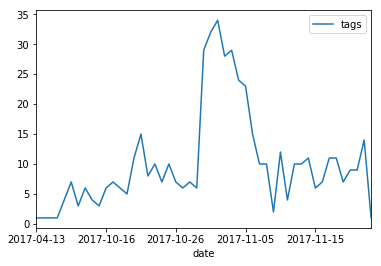

In [67]:
## %matplotlib inline
data_tags.groupby('date').count().plot()

In [75]:
data_tags.groupby('date').count()

,tags
date,
2017-04-13,1
2017-04-26,1
2017-06-22,1
2017-07-26,1
2017-10-10,4
2017-10-11,7
2017-10-12,3
2017-10-13,6
2017-10-14,4


In [ ]:
# 싱글 아이섀도우들의 이번 아리따움 11월 세일 기간은 10월 30일(월)~11월 5일(일) 일주일간


In [72]:
# data_tags[(data_tags['date'] > '2017-10-30') and (data_tags['date']< '2017-11-10')]
s = data_tags[(data_tags['date'] > '2017-10-30')&(data_tags['date'] < '2017-11-01')]
print(len(s))
print(s)


32
           date                                               tags
309  2017-10-31             [#과자, #생일선물, #편지, #모노아이즈, #친구, #사랑행❣️]
314  2017-10-31  [#아리따움, #모노아이즈, #마이웨딩모던파탈, #모노아이즈마이웨딩, #모노아이즈모...
313  2017-10-31  [#171031, #화요일, #오늘, #데일리, #2017, #halloween, ...
312  2017-10-31  [#motd, #화장기록, #이거발랐so, #코덕, #코덕스타그램, #코덕맞팔, #...
311  2017-10-31  [#아리따움, #모노아이즈, #깨져버린, #이탈리안잡, #일차로밖에떨구기, #이차로...
310  2017-10-31  [#motd, #화장기록, #이거발랐so, #코덕, #코덕스타그램, #코덕맞팔, #...
308  2017-10-31  [#한정판, #득템, #라네즈, #라네즈투톤립바, #모노아이즈, #선물, #감사합니...
320  2017-10-31  [#오늘의눈화장, #오늘의화장, #눈, #눈화장, #눈화장의중요성, #눈스타그램, ...
306  2017-10-31  [#MauveOTD세일해서, #아멜리, #마카롱그레이, #로즈브라운, #아리따움, ...
305  2017-10-31  [#jye_motd, #아리따움, #모노아이즈, #미샤, #이탈프리즘섀도우, #나스...
304  2017-10-31  [#룸하울, #룸리뷰, #룸발색, #샤인픽스아이즈No, #시나몬로즈펄, #맘보무드맘...
303  2017-10-31  [#달, #대학, #대학교, #selfie, #selfies, #selca, #fo...
302  2017-10-31  [#jye_motd, #아리따움, #모노아이즈, #에뛰드하우스, #맥, #motd,...
315  2017-10-31  [#Repost, #모노아이즈, #샤인픽스아이즈, #가을아이섀도, #할로윈아

In [ ]:
data_tags['date']

# tag분석

In [28]:
# 데이터분석: 태그
datas_tags=[]
for data in datas:
    tag_text = []
    for tag in data['tags']:
        tag_text.append(tag[1:])
    datas_tags.append(tag_text)
#     print(data['tags'])
print(len(datas_tags))
print(datas_tags[0])

500
['모노아이즈', '소셜라이트', '이탈리안잡']


In [29]:
tag_s=[]
for tags in datas_tags:
    for tag in tags:
        tag_s.append(tag)

tag_s=set(tag_s)

print(len(set(tag_s)))
print(set(tag_s))


2815
{'짱', '조치원', '는책상', '오늘의화장품', 'bornthiswayfoundation', '😭', '강제선물', 'delicatedrift', '언팔ㅗ', '투샷', '잠옷', '퍼플카카오라떼', '못된고양이', '할로윈메이크업', '공부', '미샤', '색깔이쁘다', '겔랑', '굿나잇🌘', '언팔', '버건디', '코랄세레나데첨엔', '소통해요', '쿨톤섀도우', '언팔금지', '지름', '쿨톤음영', '패밀리세일', '월넛브라운', '라네즈', '호박볼펜', 'snowball', '韓国好きな人と繋がりたい', 'etudehouse', '시작', '브라운레드', 'powerofmakeupEYES:', '모노아이즈트러플', '추워', '다이아몬드', '홀리졸리', '섀도우정리', '발색심쿵', '롯데리아', '더블래스팅', '다크체리콕', 'nars', '아벤느', 'threecosmeticsEye', '국제시장', '깨졌다', '태양계여신', '퍼플라이트', '잘구운마시멜로🤡', 'IOPE10', '모노아이즈1플1', '휠라딸기우유', '분위기여신', '메이크업추천', '스테레오', '마이웨딩모던파탈', '꿀조합', '코드', '💕', '수능화이팅‼️', '고르고고르고또고름', '각각한번발색두번발색', '바이플라워오토아이브로우02다크브라운그린', '금펄😍', '제품후기', '🍓', '공유하면', '구미', 'makeupartist', 'blackorchid', '화장실', '아이디얼딥클렌징오일', '맞팔댓글로👇', '완팬', '상큼자몽티', '흡혈귀', '에이지투웨니스', 'pk211', '택시열정', '모노아이즈발색샷', '골드', '진저파우더', 'toofaced', '슈가볼쿠션블러셔', '신발', 'lovstagram', '블러셔는', '치과천사', 'instabeauty', '스타일래쉬003', '처음', '예쁜핸드폰케이스', '비실크파운데이션', '시멘트', '가야지', 'snowvamera', '정썬풀메', 'motd⠀⠀⠀⠀⠀⠀🍭

In [14]:
print(datas_tags)

[['봄웜톤', 'mamonde', '마몽드', '크리미틴트컬러밤인텐스'], ['홀리카홀리카', '자몽타르트', '봄웜톤', '웜톤아이섀도우1'], ['에스쁘아', '오렌지피버', 'espoir', 'orangefever', '물광섀도우', '오렌지', '펄섀도우', 'selca', 'selfie', 'selstagram', 'fff', 'lfl', 'instalike', '소통', '맞팔', '일상', '셀스타그램', '셀카', '셀피', '새벽', '얼스타그램', 'cosmetics', 'shadow', 'eyeshadow', '봄웜', '봄웜톤'], ['퍼스널컬러', '쿨톤', '웜톤', '겨울쿨톤', '봄웜톤'], ['색단비컬러컨설팅', '색단비여름쿨톤이라', '봄웜톤', '봄라이트'], ['퍼스널컬러', '봄웜톤', '여름쿨톤', '겨울쿨톤'], ['웜톤', '봄웜톤', '퍼스널컬러', '퍼스널컬러진단'], ['봄웜클리어', '봄웜비비드', '봄웜톤'], ['코치스스로우다운', '기록보단', '젬봇대', '겨울쿨톤', '봄웜톤'], ['해변에선코코넛', '시럽빼고테이크아웃', '200년된초코가게', '샤인픽스아이즈', '코코넛베이', '맥', '루비우', '코스메틱', '코덕', '화장품', '뷰티', '뷰티스타그램', 'beauty', 'instabeauty', 'makeup', '메이크업', '웜톤', '봄웜톤', 'motd', 'eotd', '좋아요', '소통해요', '코덕소통해요', '맞팔', '선팔', '뉼쓰', '뉼쓰의화장품'], ['톤체성', '비욘드컬러눈부실', '봄웜톤', '톤알러', '퍼스널컬러', '퍼스널컬러진단', '직장인', '직딩', '이미지컨설팅', '예승', '항공과', '이미지메이킹', '신촌', '이대역', '셀카', '셀피', '일상', '데일리그램', '코덕', '코덕스타그램', 'selfie', 'instadaily', 'makeupoftheday', 'makeupporn', 'dailymakeup'], ['뚜엉이

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [30]:
from collections import Counter

# 빈도 높은 단어들만 가져오기
words_count=Counter()
for tags in datas_tags:
    words_count.update(tags)

words_most = []
words_most_onlyword=[]
for word,count in words_count.most_common(500):
    words_most.append((word,count))
    words_most_onlyword.append(word)
    
print(words_most[:100])  

[('모노아이즈', 483), ('아리따움', 318), ('코덕', 110), ('섀도우', 93), ('motd', 84), ('메이크업', 69), ('화장품', 63), ('일상', 63), ('코덕스타그램', 51), ('데일리', 49), ('뷰티스타그램', 47), ('뷰티', 46), ('makeup', 46), ('에뛰드하우스', 45), ('cosmetics', 39), ('아이섀도우', 37), ('이니스프리', 37), ('에뛰드', 34), ('맞팔', 34), ('미샤', 32), ('aritaum', 31), ('좋아요', 31), ('얼쓰', 31), ('바비브라운', 31), ('아이메이크업', 31), ('beauty', 30), ('selfie', 30), ('셀스타그램', 30), ('소통', 29), ('monoeyes', 28), ('셀카', 27), ('뷰스타그램', 27), ('daily', 26), ('코스메틱', 26), ('샤인픽스아이즈', 25), ('팔로우', 22), ('이탈리안잡', 21), ('더페이스샵', 21), ('코덕맞팔', 21), ('마젠타', 21), ('오늘의화장', 20), ('화장', 20), ('선팔', 20), ('eotd', 19), ('캐시미어', 19), ('eyeshadow', 19), ('눈화장', 19), ('트러플', 19), ('일상스타그램', 19), ('키스미', 19), ('맥', 18), ('진저파우더', 18), ('페리페라', 18), ('잭버건디', 18), ('1', 18), ('kbeauty', 16), ('섀도우추천', 16), ('드라이로즈', 16), ('eyemakeup', 15), ('데일리메이크업', 15), ('shadow', 15), ('드레스코드', 15), ('발색샷', 15), ('소셜라이트', 14), ('삐아', 13), ('스틸라', 13), ('코스메틱덕후', 12), ('테이크댓', 12), ('마몽드', 12), ('세일'

## 1) 워드클라우드

(-0.5, 399.5, 199.5, -0.5)

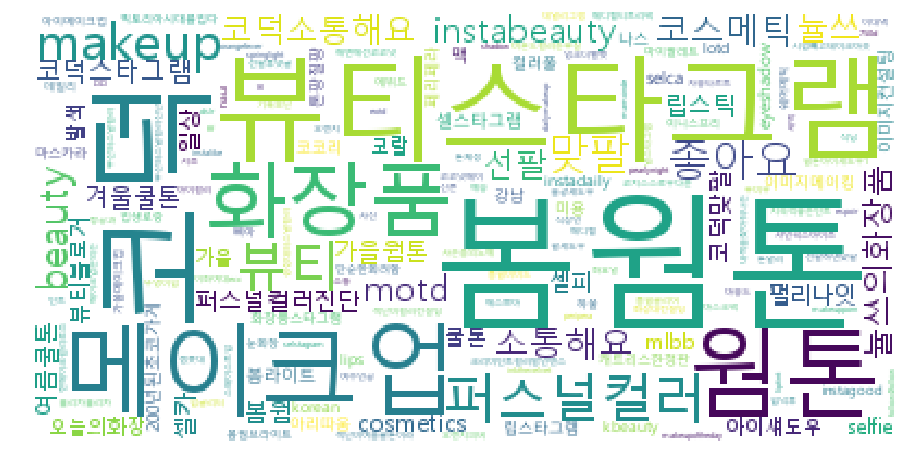

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from wordcloud import WordCloud

tmp = dict(words_most)
wordcloud=WordCloud(font_path="c:/Windows/Fonts/malgun.ttf", relative_scaling=0.2, 
                    background_color="white", max_words=200).generate_from_frequencies(tmp)    #font_step=5
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
# plt.savefig('./data_구청장/wordcloud(white)_명사만_중복미제외.png')

## 2) SNA

In [53]:
# 단어 관계 행렬 쓰기 
from collections import Counter
from itertools import combinations

word_cooc_mat=Counter()

for line in datas_tags:
    for word1, word2 in combinations(line,2):
        if word1 == word2 :   #동일한 단어간의 벡터는 계산하지 않음
            continue
        elif word_cooc_mat[(word2,word1)]>=1:
            word_cooc_mat[(word2,word1)]+=1
        else:
            word_cooc_mat[(word1,word2)]+=1


In [54]:
# 단어관계 행렬  counter 형태 --> 리스트 내 튜플 형태로 수정 --> 정렬하기

word_coocs=[]
for words, count in word_cooc_mat.items():
    word_coocs.append((words[0],words[1],count))
# print(word_coocs)    
        
sorted_word_coocs = sorted(word_coocs, key=lambda x: x[2], reverse=True)   # 정렬하기
print(sorted_word_coocs)

[('모노아이즈', '아리따움', 326), ('모노아이즈', '코덕', 108), ('섀도우', '모노아이즈', 95), ('모노아이즈', 'motd', 84), ('아리따움', '코덕', 81), ('아리따움', '섀도우', 72), ('모노아이즈', '메이크업', 68), ('모노아이즈', '화장품', 63), ('모노아이즈', '일상', 63), ('모노아이즈', '코덕스타그램', 52), ('아리따움', 'motd', 49), ('아리따움', '화장품', 48), ('데일리', '모노아이즈', 48), ('모노아이즈', '뷰티', 47), ('모노아이즈', '뷰티스타그램', 46), ('코덕', 'motd', 46), ('에뛰드하우스', '모노아이즈', 46), ('코덕', '코덕스타그램', 46), ('아리따움', '일상', 44), ('모노아이즈', 'makeup', 44), ('모노아이즈', '이니스프리', 43), ('아리따움', '메이크업', 43), ('아리따움', '코덕스타그램', 39), ('에뛰드', '모노아이즈', 38), ('cosmetics', '모노아이즈', 37), ('이니스프리', '아리따움', 37), ('모노아이즈', '아이메이크업', 36), ('아이섀도우', '모노아이즈', 36), ('코덕', '메이크업', 36), ('아리따움', '뷰티', 35), ('모노아이즈', '맞팔', 34), ('모노아이즈', '미샤', 33), ('에뛰드하우스', '아리따움', 33), ('아리따움', '데일리', 32), ('아리따움', 'makeup', 32), ('모노아이즈', '얼쓰', 32), ('아리따움', '뷰티스타그램', 32), ('바비브라운', '모노아이즈', 31), ('코덕', '화장품', 31), ('코덕', '뷰티', 31), ('코덕', '뷰티스타그램', 30), ('모노아이즈', '셀스타그램', 30), ('aritaum', '모노아이즈', 30), ('아리따움', 'aritaum', 30), ('모노아이즈

In [55]:
#그래프 그리기
import networkx as nx
import matplotlib.pyplot as plt
import sys

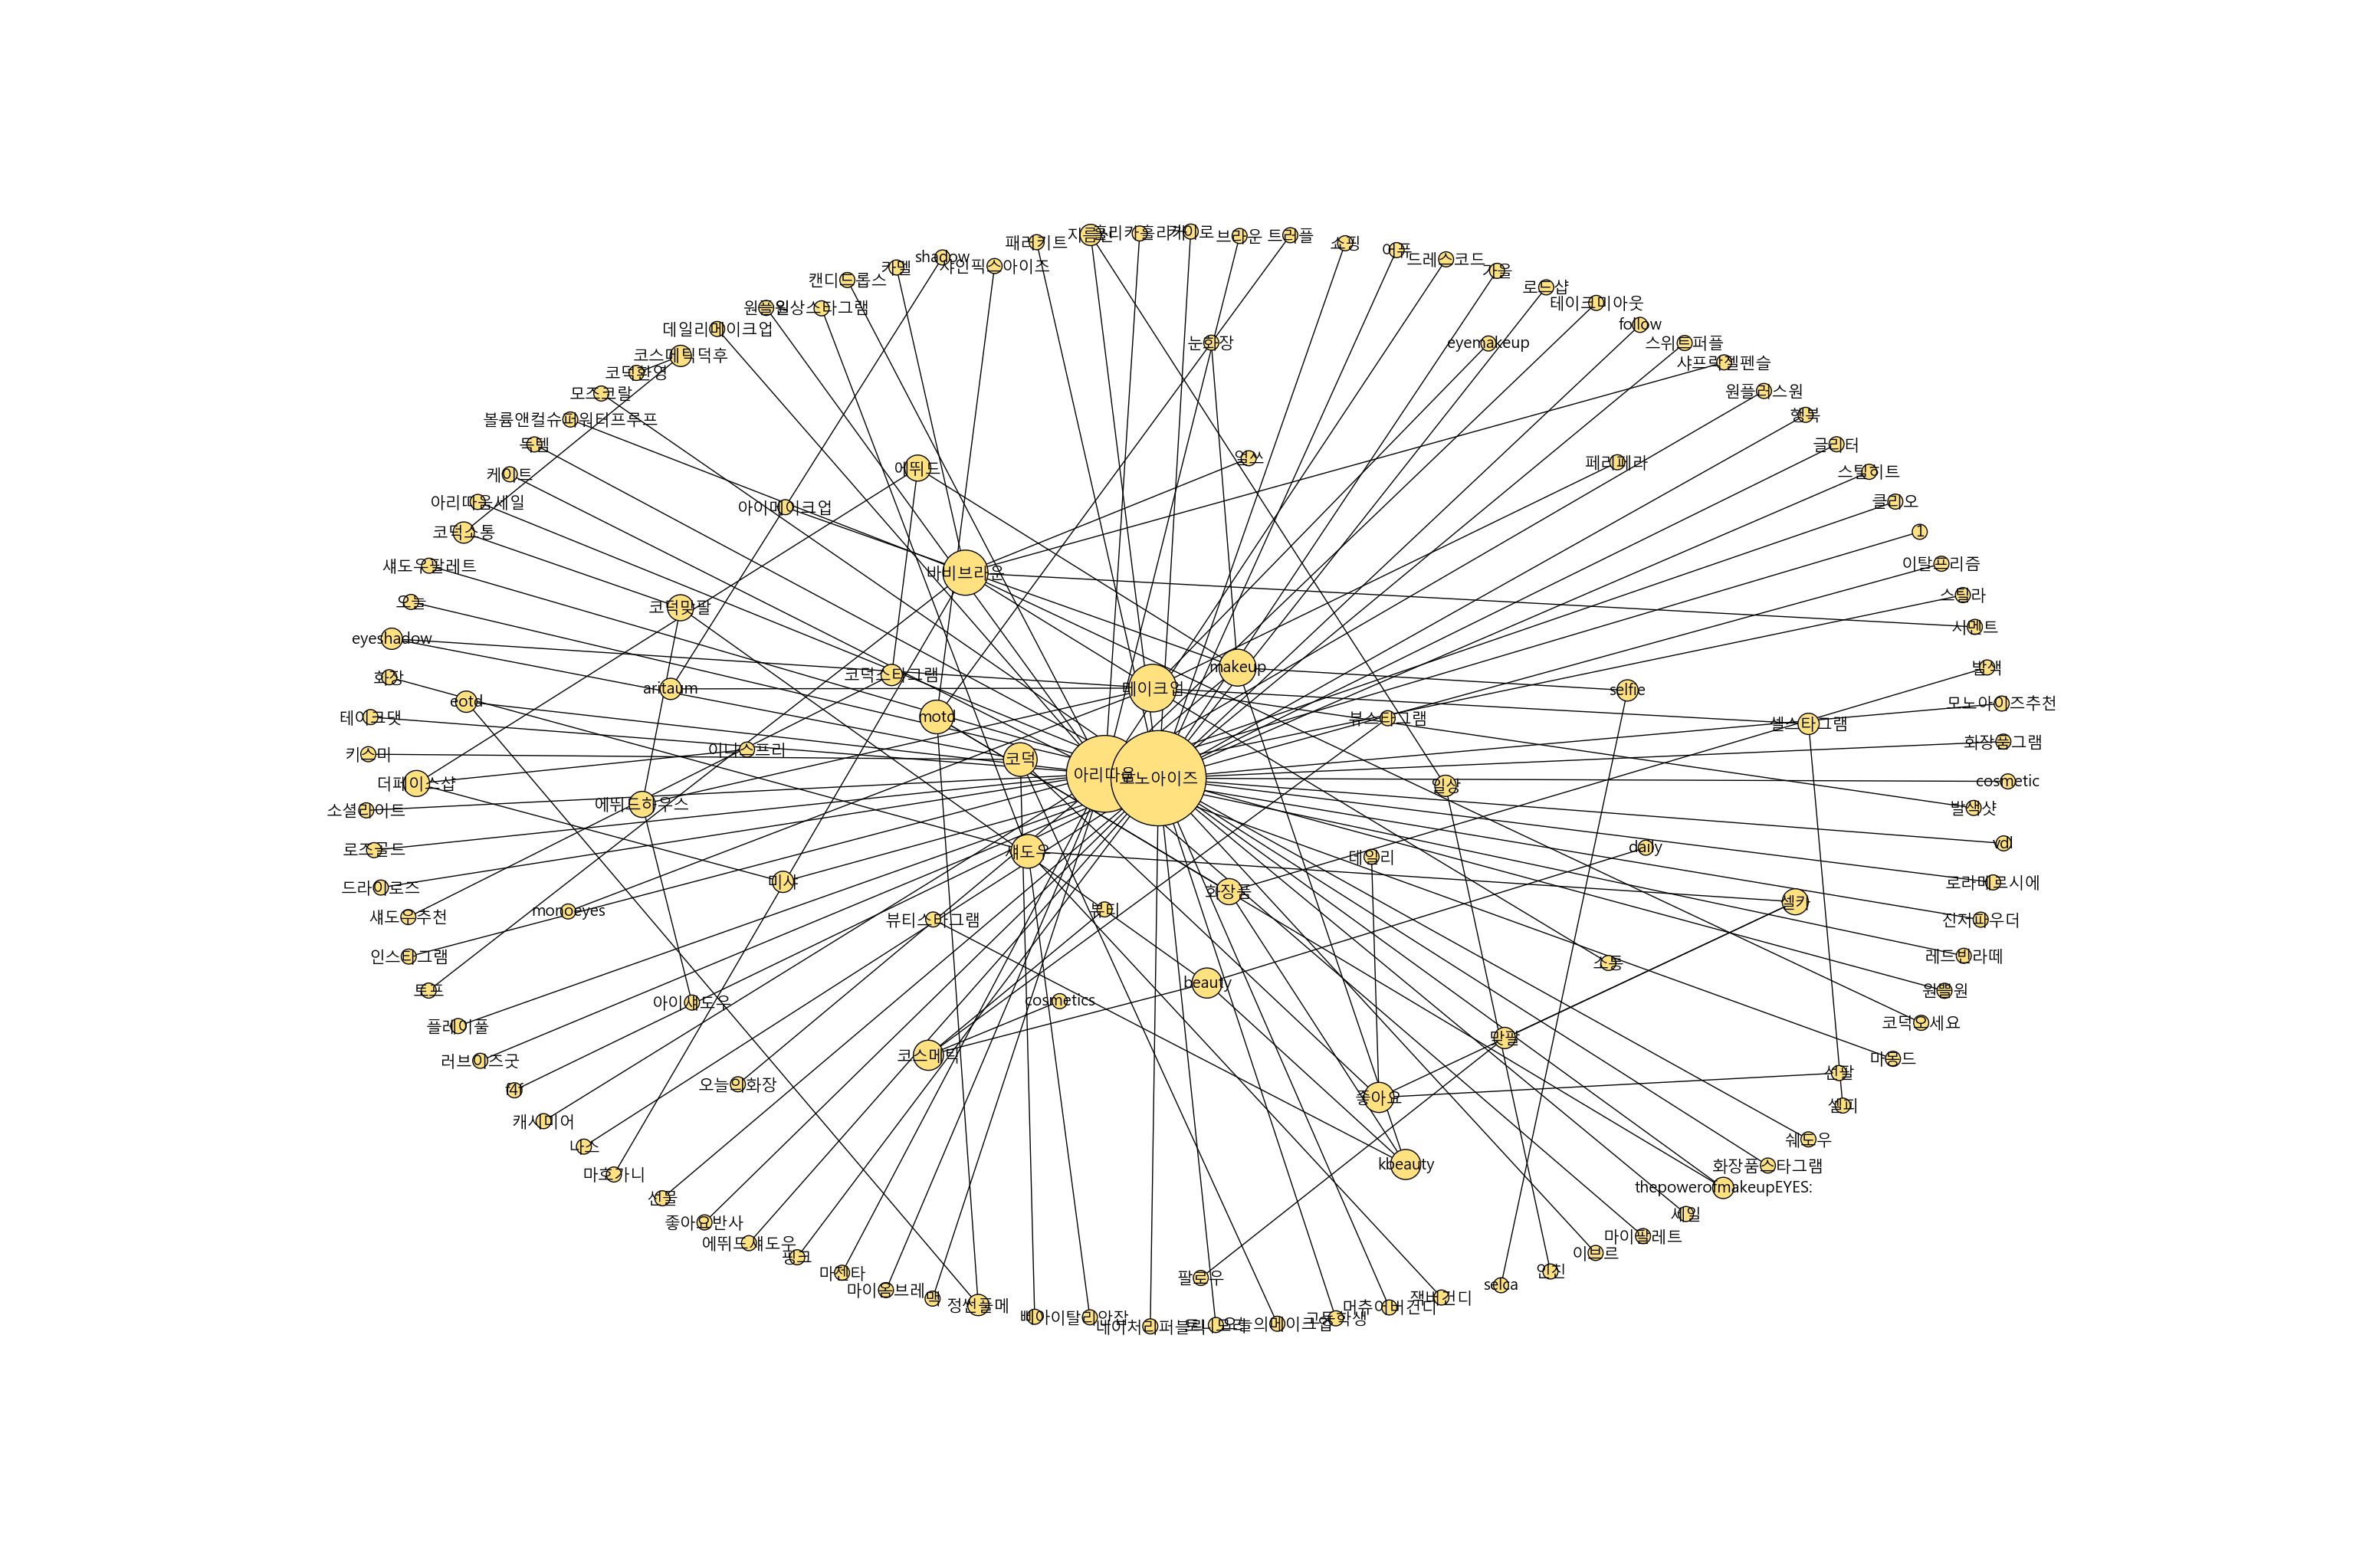

In [63]:
# 그래프 그리기

G= nx.Graph()

for word1, word2, count in sorted_word_coocs[:500]:    #상위 n개로만 그림 그리기
    G.add_edge(word1, word2, weight=count)
    
T = nx.minimum_spanning_tree(G)

nodes = nx.nodes(T)
degrees = nx.degree(T)

node_size = []

for node in nodes:
    ns = degrees[node]*200
    
    node_size.append(ns)
    
if sys.platform in ["win32", "win64"]:
    font_name = "malgun gothic"
elif sys.platform == "darwin":
    fornt_name = "AppleGothic"
    
plt.figure(figsize=(30,20))    
nx.draw(T,
       pos=nx.fruchterman_reingold_layout(G, k=0.5),
       node_size=node_size,
       node_color="#FFE27F",
       font_family=font_name,
       label_pos=0, #0=head, 0.5=center, 1=tail
        with_labels=True,
        font_size=15 )
# plt.savefig("./data_구청장/명사만_중복포함_관계상위100(1).png")
plt.axis("off")

plt.show()